In [28]:
import kagglehub
path = kagglehub.dataset_download("javaidahmadwani/lc25000")

Using Colab cache for faster access to the 'lc25000' dataset.


In [29]:
print(f"Dataset downloaded to: {path}")

Dataset downloaded to: /kaggle/input/lc25000


# Lung Cancer Classification - Model Comparison
This notebook compares three CNN architectures for lung cancer classification:
1. EfficientNetB1
2. VGG16
3. ResNet50

Using the LC25000 dataset with transfer learning approach.

## Import Required Libraries

In [30]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from PIL import Image
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
from tqdm import tqdm

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

PyTorch version: 2.9.0+cu126
Torchvision version: 0.24.0+cu126
CUDA Available: True
CUDA Device: Tesla T4
Number of GPUs: 1

Using device: cuda


## Data Preparation and Preprocessing

In [31]:
# Explore the downloaded dataset structure first
print(f"Base path: {path}")
print("\nExploring directory structure...")

# Function to explore directory tree
def explore_directory(dir_path, max_depth=3, current_depth=0, prefix=""):
    if current_depth >= max_depth:
        return
    try:
        items = os.listdir(dir_path)
        for item in items[:10]:  # Limit to first 10 items per directory
            item_path = os.path.join(dir_path, item)
            if os.path.isdir(item_path):
                print(f"{prefix}📁 {item}/")
                explore_directory(item_path, max_depth, current_depth + 1, prefix + "  ")
            else:
                print(f"{prefix}📄 {item}")
    except PermissionError:
        print(f"{prefix}❌ Permission denied")
    except Exception as e:
        print(f"{prefix}❌ Error: {e}")

explore_directory(path, max_depth=4)

# Try to find the lung_image_sets directory
print("\n" + "="*60)
print("Searching for lung image dataset...")
print("="*60)

# Common possible paths
possible_paths = [
    path,
    os.path.join(path, "lung_colon_image_set", "lung_image_sets"),
    os.path.join(path, "lung_image_sets"),
    os.path.join(path, "lc25000", "lung_colon_image_set", "lung_image_sets"),
]

# Walk through the directory to find lung images
dataset_path = None
for root, dirs, files in os.walk(path):
    if 'lung_aca' in dirs or 'lung_scc' in dirs or 'lung_n' in dirs:
        dataset_path = root
        print(f"✅ Found lung dataset at: {dataset_path}")
        break

if dataset_path is None:
    # If not found, list what's in the base path
    print("\n📂 Contents of base path:")
    for item in os.listdir(path):
        print(f"  - {item}")

    # Try to use the path directly if it contains class folders
    if os.path.isdir(path):
        items = os.listdir(path)
        if any('lung' in item.lower() for item in items):
            dataset_path = path
            print(f"\n✅ Using base path as dataset path: {dataset_path}")

if dataset_path:
    # List the classes
    classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    print(f"\n📊 Classes found: {classes}")

    # Count images per class
    print("\n📈 Image counts per class:")
    for cls in classes:
        cls_path = os.path.join(dataset_path, cls)
        try:
            num_images = len([f for f in os.listdir(cls_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
            print(f"  {cls}: {num_images:,} images")
        except Exception as e:
            print(f"  {cls}: Error - {e}")
else:
    print("\n❌ Could not find lung dataset directory!")
    print("Please check the dataset structure manually.")

Base path: /kaggle/input/lc25000

Exploring directory structure...
📁 lung_colon_image_set/
  📁 Train and Validation Set/
    📁 colon_aca/
      📄 colonca637.jpeg
      📄 colonca3400.jpeg
      📄 colonca783.jpeg
      📄 colonca3927.jpeg
      📄 colonca4109.jpeg
      📄 colonca95.jpeg
      📄 colonca488.jpeg
      📄 colonca2140.jpeg
      📄 colonca3260.jpeg
      📄 colonca1481.jpeg
    📁 lung_aca/
      📄 lungaca2056.jpeg
      📄 lungaca1914.jpeg
      📄 lungaca3803.jpeg
      📄 lungaca861.jpeg
      📄 lungaca4646.jpeg
      📄 lungaca918.jpeg
      📄 lungaca452.jpeg
      📄 lungaca2826.jpeg
      📄 lungaca4709.jpeg
      📄 lungaca2491.jpeg
    📁 lung_scc/
      📄 lungscc1930.jpeg
      📄 lungscc1441.jpeg
      📄 lungscc4038.jpeg
      📄 lungscc2504.jpeg
      📄 lungscc1129.jpeg
      📄 lungscc3862.jpeg
      📄 lungscc1153.jpeg
      📄 lungscc1918.jpeg
      📄 lungscc3360.jpeg
      📄 lungscc2005.jpeg
    📁 colon_n/
      📄 colonn2355.jpeg
      📄 colonn2332.jpeg
      📄 colonn441.jpeg
  

In [32]:
# Configuration
IMG_SIZE = 224  # Using 224x224 for better compatibility with pre-trained models
BATCH_SIZE = 32
EPOCHS = 25
VALIDATION_SPLIT = 0.2
LEARNING_RATE = 0.001

# Custom Dataset class
class LungCancerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_names = []

        # Get class directories
        classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_names = classes
        self.class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

        # Load all image paths and labels
        for cls in classes:
            cls_path = os.path.join(root_dir, cls)
            cls_idx = self.class_to_idx[cls]
            for img_name in os.listdir(cls_path):
                if img_name.endswith(('.png', '.jpg', '.jpeg')):
                    self.images.append(os.path.join(cls_path, img_name))
                    self.labels.append(cls_idx)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Data augmentation and preprocessing for training
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Only normalization for validation
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create full dataset
full_dataset = LungCancerDataset(dataset_path, transform=None)
class_names = full_dataset.class_names
num_classes = len(class_names)

print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")
print(f"Total images: {len(full_dataset)}")

# Split dataset into train and validation
from torch.utils.data import random_split
train_size = int((1 - VALIDATION_SPLIT) * len(full_dataset))
val_size = len(full_dataset) - train_size
train_indices, val_indices = torch.utils.data.random_split(
    range(len(full_dataset)),
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Create separate datasets with different transforms
class SubsetDataset(Dataset):
    def __init__(self, dataset, indices, transform):
        self.dataset = dataset
        self.indices = list(indices)
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        original_idx = self.indices[idx]
        img_path = self.dataset.images[original_idx]
        label = self.dataset.labels[original_idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

train_dataset = SubsetDataset(full_dataset, train_indices, train_transform)
val_dataset = SubsetDataset(full_dataset, val_indices, val_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"\nTraining samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Batches per epoch (train): {len(train_loader)}")
print(f"Batches per epoch (val): {len(val_loader)}")

Class names: ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']
Number of classes: 5
Total images: 22501

Training samples: 18000
Validation samples: 4501
Batches per epoch (train): 563
Batches per epoch (val): 141


## Visualize Sample Images

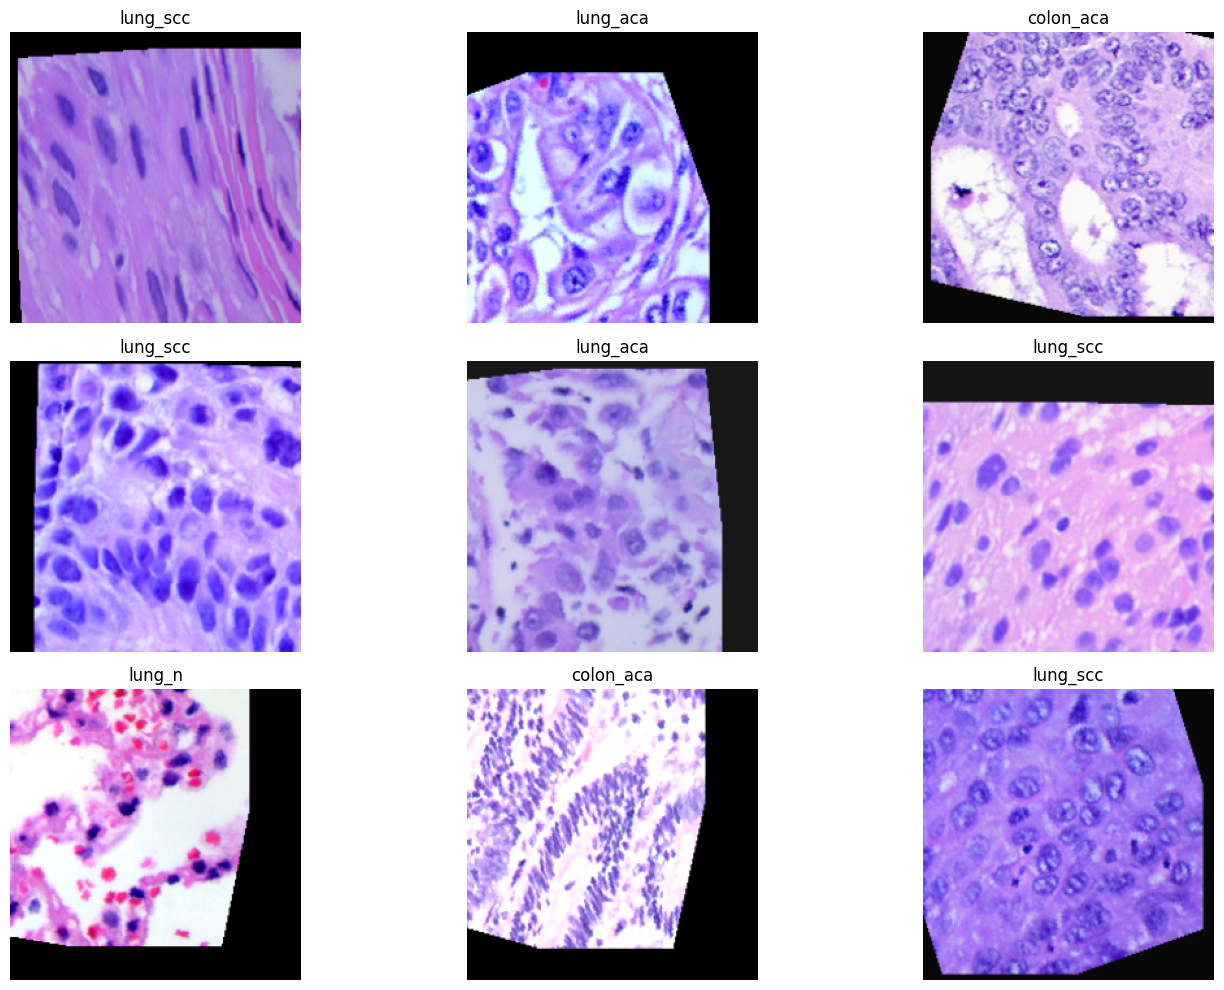

In [33]:
# Display sample images
plt.figure(figsize=(15, 10))

# Denormalization for display
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

for i in range(min(9, len(images))):
    plt.subplot(3, 3, i+1)

    # Convert tensor to image
    img = images[i]
    img = inv_normalize(img)
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    plt.title(class_names[labels[i].item()])
    plt.axis('off')

plt.tight_layout()
plt.show()

## Define Callbacks for Training

In [34]:
# Training function with early stopping and learning rate reduction
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, model_name):
    """Train a PyTorch model with early stopping and learning rate scheduling"""

    # Learning rate scheduler (verbose is not a valid parameter in PyTorch)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-7
    )

    # Early stopping
    early_stopping = EarlyStopping(patience=5, verbose=True)

    # History tracking
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    print(f"\nTraining {model_name}...")
    print("="*70)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

            train_pbar.set_postfix({
                'loss': f'{train_loss/len(train_loader):.4f}',
                'acc': f'{100.*train_correct/train_total:.2f}%'
            })

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]  ')
            for inputs, labels in val_pbar:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

                val_pbar.set_postfix({
                    'loss': f'{val_loss/len(val_loader):.4f}',
                    'acc': f'{100.*val_correct/val_total:.2f}%'
                })

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = val_correct / val_total

        # Update history
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_accuracy)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)

        # Print epoch summary
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}')
        print(f'  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
        print(f'  Learning Rate: {optimizer.param_groups[0]["lr"]:.2e}')

        # Learning rate scheduling
        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(avg_val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        if old_lr != new_lr:
            print(f'  Learning rate reduced: {old_lr:.2e} -> {new_lr:.2e}')

        # Early stopping check
        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print("\nEarly stopping triggered!")
            model.load_state_dict(early_stopping.best_model)
            break

    # Load best model
    if early_stopping.best_model is not None:
        model.load_state_dict(early_stopping.best_model)
        print("\nRestored best model weights")

    return history

## Model 1: EfficientNetB1

In [35]:
# Build EfficientNetB1 model
def build_efficientnet_model(num_classes=3):
    """Build EfficientNet-B1 model with frozen base and custom classifier"""

    # Load pre-trained EfficientNet-B1
    model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.IMAGENET1K_V1)

    # Freeze base model parameters
    for param in model.parameters():
        param.requires_grad = False

    # Replace classifier with custom layers
    num_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(num_features, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(256, 128),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.3),
        nn.Linear(128, num_classes)
    )

    return model

# Create model
efficientnet_model = build_efficientnet_model(num_classes=num_classes)
efficientnet_model = efficientnet_model.to(device)

# Print model summary
print("EfficientNetB1 Model Architecture:")
print("="*70)
print(efficientnet_model)

# Count parameters
total_params = sum(p.numel() for p in efficientnet_model.parameters())
trainable_params = sum(p.numel() for p in efficientnet_model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {total_params - trainable_params:,}")

EfficientNetB1 Model Architecture:
EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
         

In [36]:
# Train EfficientNetB1
criterion = nn.CrossEntropyLoss()
optimizer_efficientnet = optim.Adam(efficientnet_model.parameters(), lr=LEARNING_RATE)

history_efficientnet = train_model(
    efficientnet_model,
    train_loader,
    val_loader,
    criterion,
    optimizer_efficientnet,
    EPOCHS,
    "EfficientNetB1"
)


Training EfficientNetB1...


Epoch 1/25 [Val]  : 100%|██████████| 141/141 [00:38<00:00,  3.67it/s, loss=0.1850, acc=93.38%]



Epoch 1/25:
  Train Loss: 0.3175, Train Acc: 0.8874
  Val Loss: 0.1850, Val Acc: 0.9338
  Learning Rate: 1.00e-03


Epoch 2/25 [Val]  : 100%|██████████| 141/141 [00:39<00:00,  3.59it/s, loss=0.1280, acc=95.22%]



Epoch 2/25:
  Train Loss: 0.2113, Train Acc: 0.9242
  Val Loss: 0.1280, Val Acc: 0.9522
  Learning Rate: 1.00e-03


Epoch 3/25 [Val]  : 100%|██████████| 141/141 [00:34<00:00,  4.03it/s, loss=0.1364, acc=94.89%]



Epoch 3/25:
  Train Loss: 0.1852, Train Acc: 0.9313
  Val Loss: 0.1364, Val Acc: 0.9489
  Learning Rate: 1.00e-03
EarlyStopping counter: 1 out of 5


Epoch 4/25 [Val]  : 100%|██████████| 141/141 [00:34<00:00,  4.12it/s, loss=0.1039, acc=96.20%]



Epoch 4/25:
  Train Loss: 0.1805, Train Acc: 0.9333
  Val Loss: 0.1039, Val Acc: 0.9620
  Learning Rate: 1.00e-03


Epoch 5/25 [Val]  : 100%|██████████| 141/141 [00:34<00:00,  4.08it/s, loss=0.1155, acc=95.80%]



Epoch 5/25:
  Train Loss: 0.1662, Train Acc: 0.9378
  Val Loss: 0.1155, Val Acc: 0.9580
  Learning Rate: 1.00e-03
EarlyStopping counter: 1 out of 5


Epoch 6/25 [Val]  : 100%|██████████| 141/141 [00:35<00:00,  3.99it/s, loss=0.0914, acc=96.36%]



Epoch 6/25:
  Train Loss: 0.1670, Train Acc: 0.9406
  Val Loss: 0.0914, Val Acc: 0.9636
  Learning Rate: 1.00e-03


Epoch 7/25 [Val]  : 100%|██████████| 141/141 [00:35<00:00,  3.98it/s, loss=0.0708, acc=97.31%]



Epoch 7/25:
  Train Loss: 0.1577, Train Acc: 0.9407
  Val Loss: 0.0708, Val Acc: 0.9731
  Learning Rate: 1.00e-03


Epoch 8/25 [Val]  : 100%|██████████| 141/141 [00:33<00:00,  4.18it/s, loss=0.0786, acc=97.13%]



Epoch 8/25:
  Train Loss: 0.1613, Train Acc: 0.9410
  Val Loss: 0.0786, Val Acc: 0.9713
  Learning Rate: 1.00e-03
EarlyStopping counter: 1 out of 5


Epoch 9/25 [Val]  : 100%|██████████| 141/141 [00:35<00:00,  3.98it/s, loss=0.1005, acc=96.65%]



Epoch 9/25:
  Train Loss: 0.1527, Train Acc: 0.9431
  Val Loss: 0.1005, Val Acc: 0.9665
  Learning Rate: 1.00e-03
EarlyStopping counter: 2 out of 5


Epoch 10/25 [Val]  : 100%|██████████| 141/141 [00:35<00:00,  4.02it/s, loss=0.1047, acc=96.25%]



Epoch 10/25:
  Train Loss: 0.1459, Train Acc: 0.9472
  Val Loss: 0.1047, Val Acc: 0.9625
  Learning Rate: 1.00e-03
EarlyStopping counter: 3 out of 5


Epoch 11/25 [Val]  : 100%|██████████| 141/141 [00:33<00:00,  4.19it/s, loss=0.0797, acc=97.07%]



Epoch 11/25:
  Train Loss: 0.1415, Train Acc: 0.9502
  Val Loss: 0.0797, Val Acc: 0.9707
  Learning Rate: 1.00e-03
  Learning rate reduced: 1.00e-03 -> 5.00e-04
EarlyStopping counter: 4 out of 5


Epoch 12/25 [Val]  : 100%|██████████| 141/141 [00:35<00:00,  4.01it/s, loss=0.0647, acc=97.36%]



Epoch 12/25:
  Train Loss: 0.1310, Train Acc: 0.9518
  Val Loss: 0.0647, Val Acc: 0.9736
  Learning Rate: 5.00e-04


Epoch 13/25 [Val]  : 100%|██████████| 141/141 [00:34<00:00,  4.08it/s, loss=0.0621, acc=97.49%]



Epoch 13/25:
  Train Loss: 0.1236, Train Acc: 0.9566
  Val Loss: 0.0621, Val Acc: 0.9749
  Learning Rate: 5.00e-04


Epoch 14/25 [Val]  : 100%|██████████| 141/141 [00:33<00:00,  4.25it/s, loss=0.0668, acc=97.53%]



Epoch 14/25:
  Train Loss: 0.1266, Train Acc: 0.9547
  Val Loss: 0.0668, Val Acc: 0.9753
  Learning Rate: 5.00e-04
EarlyStopping counter: 1 out of 5


Epoch 15/25 [Val]  : 100%|██████████| 141/141 [00:34<00:00,  4.07it/s, loss=0.0599, acc=97.87%]



Epoch 15/25:
  Train Loss: 0.1192, Train Acc: 0.9569
  Val Loss: 0.0599, Val Acc: 0.9787
  Learning Rate: 5.00e-04


Epoch 16/25 [Val]  : 100%|██████████| 141/141 [00:35<00:00,  3.99it/s, loss=0.0648, acc=97.89%]



Epoch 16/25:
  Train Loss: 0.1180, Train Acc: 0.9576
  Val Loss: 0.0648, Val Acc: 0.9789
  Learning Rate: 5.00e-04
EarlyStopping counter: 1 out of 5


Epoch 17/25 [Val]  : 100%|██████████| 141/141 [00:33<00:00,  4.23it/s, loss=0.0622, acc=97.69%]



Epoch 17/25:
  Train Loss: 0.1167, Train Acc: 0.9579
  Val Loss: 0.0622, Val Acc: 0.9769
  Learning Rate: 5.00e-04
EarlyStopping counter: 2 out of 5


Epoch 18/25 [Val]  : 100%|██████████| 141/141 [00:33<00:00,  4.25it/s, loss=0.0632, acc=97.78%]



Epoch 18/25:
  Train Loss: 0.1141, Train Acc: 0.9582
  Val Loss: 0.0632, Val Acc: 0.9778
  Learning Rate: 5.00e-04
EarlyStopping counter: 3 out of 5


Epoch 19/25 [Val]  : 100%|██████████| 141/141 [00:34<00:00,  4.10it/s, loss=0.0649, acc=97.67%]



Epoch 19/25:
  Train Loss: 0.1170, Train Acc: 0.9573
  Val Loss: 0.0649, Val Acc: 0.9767
  Learning Rate: 5.00e-04
  Learning rate reduced: 5.00e-04 -> 2.50e-04
EarlyStopping counter: 4 out of 5


Epoch 20/25 [Val]  : 100%|██████████| 141/141 [00:34<00:00,  4.08it/s, loss=0.0632, acc=97.84%]



Epoch 20/25:
  Train Loss: 0.1111, Train Acc: 0.9595
  Val Loss: 0.0632, Val Acc: 0.9784
  Learning Rate: 2.50e-04
EarlyStopping counter: 5 out of 5

Early stopping triggered!

Restored best model weights


## Model 2: VGG16

In [38]:
# Train VGG16
optimizer_vgg16 = optim.Adam(vgg16_model.parameters(), lr=LEARNING_RATE)
istory_vgg16 = train_model(
    vgg16_model,
    train_loader,
    val_loader,
    criterion,
    optimizer_vgg16,
    EPOCHS,
    "VGG16"
)



Training VGG16...


Epoch 1/25 [Val]  : 100%|██████████| 141/141 [00:39<00:00,  3.53it/s, loss=0.2012, acc=93.29%]



Epoch 1/25:
  Train Loss: 0.3854, Train Acc: 0.8564
  Val Loss: 0.2012, Val Acc: 0.9329
  Learning Rate: 1.00e-03


Epoch 2/25 [Val]  : 100%|██████████| 141/141 [00:40<00:00,  3.49it/s, loss=0.1386, acc=95.22%]



Epoch 2/25:
  Train Loss: 0.2579, Train Acc: 0.9065
  Val Loss: 0.1386, Val Acc: 0.9522
  Learning Rate: 1.00e-03


Epoch 3/25 [Val]  : 100%|██████████| 141/141 [00:40<00:00,  3.49it/s, loss=0.1544, acc=94.53%]



Epoch 3/25:
  Train Loss: 0.2221, Train Acc: 0.9183
  Val Loss: 0.1544, Val Acc: 0.9453
  Learning Rate: 1.00e-03
EarlyStopping counter: 1 out of 5


Epoch 4/25 [Val]  : 100%|██████████| 141/141 [00:40<00:00,  3.49it/s, loss=0.1963, acc=94.02%]



Epoch 4/25:
  Train Loss: 0.2059, Train Acc: 0.9266
  Val Loss: 0.1963, Val Acc: 0.9402
  Learning Rate: 1.00e-03
EarlyStopping counter: 2 out of 5


Epoch 5/25 [Val]  : 100%|██████████| 141/141 [00:40<00:00,  3.44it/s, loss=0.1468, acc=95.33%]



Epoch 5/25:
  Train Loss: 0.1967, Train Acc: 0.9293
  Val Loss: 0.1468, Val Acc: 0.9533
  Learning Rate: 1.00e-03
EarlyStopping counter: 3 out of 5


Epoch 6/25 [Val]  : 100%|██████████| 141/141 [00:46<00:00,  3.01it/s, loss=0.1312, acc=95.13%]



Epoch 6/25:
  Train Loss: 0.1857, Train Acc: 0.9316
  Val Loss: 0.1312, Val Acc: 0.9513
  Learning Rate: 1.00e-03


Epoch 7/25 [Val]  : 100%|██████████| 141/141 [00:40<00:00,  3.51it/s, loss=0.1555, acc=94.49%]



Epoch 7/25:
  Train Loss: 0.1897, Train Acc: 0.9327
  Val Loss: 0.1555, Val Acc: 0.9449
  Learning Rate: 1.00e-03
EarlyStopping counter: 1 out of 5


Epoch 8/25 [Val]  : 100%|██████████| 141/141 [00:40<00:00,  3.49it/s, loss=0.1367, acc=95.47%]



Epoch 8/25:
  Train Loss: 0.1788, Train Acc: 0.9341
  Val Loss: 0.1367, Val Acc: 0.9547
  Learning Rate: 1.00e-03
EarlyStopping counter: 2 out of 5


Epoch 9/25 [Val]  : 100%|██████████| 141/141 [00:42<00:00,  3.32it/s, loss=0.1109, acc=95.96%]



Epoch 9/25:
  Train Loss: 0.1835, Train Acc: 0.9338
  Val Loss: 0.1109, Val Acc: 0.9596
  Learning Rate: 1.00e-03


Epoch 10/25 [Val]  : 100%|██████████| 141/141 [00:40<00:00,  3.45it/s, loss=0.1591, acc=95.27%]



Epoch 10/25:
  Train Loss: 0.1767, Train Acc: 0.9383
  Val Loss: 0.1591, Val Acc: 0.9527
  Learning Rate: 1.00e-03
EarlyStopping counter: 1 out of 5


Epoch 11/25 [Val]  : 100%|██████████| 141/141 [00:40<00:00,  3.50it/s, loss=0.1581, acc=95.20%]



Epoch 11/25:
  Train Loss: 0.1733, Train Acc: 0.9392
  Val Loss: 0.1581, Val Acc: 0.9520
  Learning Rate: 1.00e-03
EarlyStopping counter: 2 out of 5


Epoch 12/25 [Val]  : 100%|██████████| 141/141 [00:40<00:00,  3.47it/s, loss=0.1312, acc=95.60%]



Epoch 12/25:
  Train Loss: 0.1669, Train Acc: 0.9407
  Val Loss: 0.1312, Val Acc: 0.9560
  Learning Rate: 1.00e-03
EarlyStopping counter: 3 out of 5


Epoch 13/25 [Val]  : 100%|██████████| 141/141 [00:40<00:00,  3.45it/s, loss=0.1454, acc=95.67%]



Epoch 13/25:
  Train Loss: 0.1738, Train Acc: 0.9381
  Val Loss: 0.1454, Val Acc: 0.9567
  Learning Rate: 1.00e-03
  Learning rate reduced: 1.00e-03 -> 5.00e-04
EarlyStopping counter: 4 out of 5


Epoch 14/25 [Val]  : 100%|██████████| 141/141 [00:41<00:00,  3.43it/s, loss=0.1142, acc=95.76%]


Epoch 14/25:
  Train Loss: 0.1424, Train Acc: 0.9479
  Val Loss: 0.1142, Val Acc: 0.9576
  Learning Rate: 5.00e-04
EarlyStopping counter: 5 out of 5

Early stopping triggered!

Restored best model weights


## Model 3: ResNet50

In [39]:
# Build ResNet50 model
def build_resnet50_model(num_classes=3):
    """Build ResNet50 model with frozen base and custom classifier"""

    # Load pre-trained ResNet50
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

    # Freeze base model parameters
    for param in model.parameters():
        param.requires_grad = False

    # Replace final fully connected layer with custom classifier
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(256, 128),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.3),
        nn.Linear(128, num_classes)
    )

    return model

# Create model
resnet50_model = build_resnet50_model(num_classes=num_classes)
resnet50_model = resnet50_model.to(device)

# Print model summary
print("ResNet50 Model Architecture:")
print("="*70)
print(resnet50_model)

# Count parameters
total_params = sum(p.numel() for p in resnet50_model.parameters())
trainable_params = sum(p.numel() for p in resnet50_model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {total_params - trainable_params:,}")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s]


ResNet50 Model Architecture:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, ke

In [40]:
# Train ResNet50
optimizer_resnet50 = optim.Adam(resnet50_model.parameters(), lr=LEARNING_RATE)

history_resnet50 = train_model(
    resnet50_model,
    train_loader,
    val_loader,
    criterion,
    optimizer_resnet50,
    EPOCHS,
    "ResNet50"
)


Training ResNet50...


Epoch 1/25 [Val]  : 100%|██████████| 141/141 [00:36<00:00,  3.82it/s, loss=0.1085, acc=96.29%]



Epoch 1/25:
  Train Loss: 0.4014, Train Acc: 0.8471
  Val Loss: 0.1085, Val Acc: 0.9629
  Learning Rate: 1.00e-03


Epoch 2/25 [Val]  : 100%|██████████| 141/141 [00:36<00:00,  3.84it/s, loss=0.1045, acc=96.00%]



Epoch 2/25:
  Train Loss: 0.2462, Train Acc: 0.9101
  Val Loss: 0.1045, Val Acc: 0.9600
  Learning Rate: 1.00e-03


Epoch 3/25 [Val]  : 100%|██████████| 141/141 [00:36<00:00,  3.85it/s, loss=0.0979, acc=95.78%]



Epoch 3/25:
  Train Loss: 0.2400, Train Acc: 0.9134
  Val Loss: 0.0979, Val Acc: 0.9578
  Learning Rate: 1.00e-03


Epoch 4/25 [Val]  : 100%|██████████| 141/141 [00:36<00:00,  3.82it/s, loss=0.1039, acc=96.25%]



Epoch 4/25:
  Train Loss: 0.2231, Train Acc: 0.9208
  Val Loss: 0.1039, Val Acc: 0.9625
  Learning Rate: 1.00e-03
EarlyStopping counter: 1 out of 5


Epoch 5/25 [Val]  : 100%|██████████| 141/141 [00:36<00:00,  3.83it/s, loss=0.0761, acc=96.82%]



Epoch 5/25:
  Train Loss: 0.2085, Train Acc: 0.9253
  Val Loss: 0.0761, Val Acc: 0.9682
  Learning Rate: 1.00e-03


Epoch 6/25 [Val]  : 100%|██████████| 141/141 [00:35<00:00,  3.93it/s, loss=0.0861, acc=96.42%]



Epoch 6/25:
  Train Loss: 0.1941, Train Acc: 0.9309
  Val Loss: 0.0861, Val Acc: 0.9642
  Learning Rate: 1.00e-03
EarlyStopping counter: 1 out of 5


Epoch 7/25 [Val]  : 100%|██████████| 141/141 [00:36<00:00,  3.85it/s, loss=0.0807, acc=96.71%]



Epoch 7/25:
  Train Loss: 0.1905, Train Acc: 0.9285
  Val Loss: 0.0807, Val Acc: 0.9671
  Learning Rate: 1.00e-03
EarlyStopping counter: 2 out of 5


Epoch 8/25 [Val]  : 100%|██████████| 141/141 [00:36<00:00,  3.84it/s, loss=0.0753, acc=97.11%]



Epoch 8/25:
  Train Loss: 0.1866, Train Acc: 0.9317
  Val Loss: 0.0753, Val Acc: 0.9711
  Learning Rate: 1.00e-03


Epoch 9/25 [Val]  : 100%|██████████| 141/141 [00:36<00:00,  3.82it/s, loss=0.0760, acc=97.02%]



Epoch 9/25:
  Train Loss: 0.1811, Train Acc: 0.9328
  Val Loss: 0.0760, Val Acc: 0.9702
  Learning Rate: 1.00e-03
EarlyStopping counter: 1 out of 5


Epoch 10/25 [Val]  : 100%|██████████| 141/141 [00:36<00:00,  3.83it/s, loss=0.1076, acc=95.96%]



Epoch 10/25:
  Train Loss: 0.1825, Train Acc: 0.9339
  Val Loss: 0.1076, Val Acc: 0.9596
  Learning Rate: 1.00e-03
EarlyStopping counter: 2 out of 5


Epoch 11/25 [Val]  : 100%|██████████| 141/141 [00:36<00:00,  3.86it/s, loss=0.0662, acc=97.31%]



Epoch 11/25:
  Train Loss: 0.1803, Train Acc: 0.9351
  Val Loss: 0.0662, Val Acc: 0.9731
  Learning Rate: 1.00e-03


Epoch 12/25 [Val]  : 100%|██████████| 141/141 [00:36<00:00,  3.82it/s, loss=0.0757, acc=97.25%]



Epoch 12/25:
  Train Loss: 0.1708, Train Acc: 0.9373
  Val Loss: 0.0757, Val Acc: 0.9725
  Learning Rate: 1.00e-03
EarlyStopping counter: 1 out of 5


Epoch 13/25 [Val]  : 100%|██████████| 141/141 [00:37<00:00,  3.81it/s, loss=0.0721, acc=97.29%]



Epoch 13/25:
  Train Loss: 0.1798, Train Acc: 0.9348
  Val Loss: 0.0721, Val Acc: 0.9729
  Learning Rate: 1.00e-03
EarlyStopping counter: 2 out of 5


Epoch 14/25 [Val]  : 100%|██████████| 141/141 [00:36<00:00,  3.85it/s, loss=0.0656, acc=97.22%]



Epoch 14/25:
  Train Loss: 0.1690, Train Acc: 0.9386
  Val Loss: 0.0656, Val Acc: 0.9722
  Learning Rate: 1.00e-03


Epoch 15/25 [Val]  : 100%|██████████| 141/141 [00:36<00:00,  3.83it/s, loss=0.0589, acc=97.62%]



Epoch 15/25:
  Train Loss: 0.1608, Train Acc: 0.9399
  Val Loss: 0.0589, Val Acc: 0.9762
  Learning Rate: 1.00e-03


Epoch 16/25 [Val]  : 100%|██████████| 141/141 [00:36<00:00,  3.81it/s, loss=0.0700, acc=97.33%]



Epoch 16/25:
  Train Loss: 0.1769, Train Acc: 0.9357
  Val Loss: 0.0700, Val Acc: 0.9733
  Learning Rate: 1.00e-03
EarlyStopping counter: 1 out of 5


Epoch 17/25 [Val]  : 100%|██████████| 141/141 [00:35<00:00,  3.96it/s, loss=0.0585, acc=97.60%]



Epoch 17/25:
  Train Loss: 0.1607, Train Acc: 0.9386
  Val Loss: 0.0585, Val Acc: 0.9760
  Learning Rate: 1.00e-03


Epoch 18/25 [Val]  : 100%|██████████| 141/141 [00:36<00:00,  3.85it/s, loss=0.0712, acc=97.33%]



Epoch 18/25:
  Train Loss: 0.1568, Train Acc: 0.9418
  Val Loss: 0.0712, Val Acc: 0.9733
  Learning Rate: 1.00e-03
EarlyStopping counter: 1 out of 5


Epoch 19/25 [Val]  : 100%|██████████| 141/141 [00:36<00:00,  3.86it/s, loss=0.0571, acc=97.64%]



Epoch 19/25:
  Train Loss: 0.1580, Train Acc: 0.9412
  Val Loss: 0.0571, Val Acc: 0.9764
  Learning Rate: 1.00e-03


Epoch 20/25 [Val]  : 100%|██████████| 141/141 [00:36<00:00,  3.81it/s, loss=0.0669, acc=97.51%]



Epoch 20/25:
  Train Loss: 0.1638, Train Acc: 0.9399
  Val Loss: 0.0669, Val Acc: 0.9751
  Learning Rate: 1.00e-03
EarlyStopping counter: 1 out of 5


Epoch 21/25 [Val]  : 100%|██████████| 141/141 [00:36<00:00,  3.82it/s, loss=0.0736, acc=97.20%]



Epoch 21/25:
  Train Loss: 0.1590, Train Acc: 0.9401
  Val Loss: 0.0736, Val Acc: 0.9720
  Learning Rate: 1.00e-03
EarlyStopping counter: 2 out of 5


Epoch 22/25 [Val]  : 100%|██████████| 141/141 [00:36<00:00,  3.84it/s, loss=0.0562, acc=97.84%]



Epoch 22/25:
  Train Loss: 0.1566, Train Acc: 0.9417
  Val Loss: 0.0562, Val Acc: 0.9784
  Learning Rate: 1.00e-03


Epoch 23/25 [Val]  : 100%|██████████| 141/141 [00:36<00:00,  3.83it/s, loss=0.0551, acc=97.62%]



Epoch 23/25:
  Train Loss: 0.1591, Train Acc: 0.9432
  Val Loss: 0.0551, Val Acc: 0.9762
  Learning Rate: 1.00e-03


Epoch 24/25 [Val]  : 100%|██████████| 141/141 [00:36<00:00,  3.87it/s, loss=0.0578, acc=97.93%]



Epoch 24/25:
  Train Loss: 0.1517, Train Acc: 0.9440
  Val Loss: 0.0578, Val Acc: 0.9793
  Learning Rate: 1.00e-03
EarlyStopping counter: 1 out of 5


Epoch 25/25 [Val]  : 100%|██████████| 141/141 [00:35<00:00,  3.92it/s, loss=0.0597, acc=97.60%]


Epoch 25/25:
  Train Loss: 0.1499, Train Acc: 0.9452
  Val Loss: 0.0597, Val Acc: 0.9760
  Learning Rate: 1.00e-03
EarlyStopping counter: 2 out of 5

Restored best model weights


## Performance Visualization and Analysis

In [41]:
# Function to plot training history
def plot_training_history(history, model_name):
    """Plot training and validation accuracy and loss"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    epochs_range = range(1, len(history['train_acc']) + 1)

    # Accuracy plot
    axes[0].plot(epochs_range, history['train_acc'], label='Training Accuracy', marker='o')
    axes[0].plot(epochs_range, history['val_acc'], label='Validation Accuracy', marker='s')
    axes[0].set_title(f'{model_name} - Accuracy Over Epochs', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Loss plot
    axes[1].plot(epochs_range, history['train_loss'], label='Training Loss', marker='o')
    axes[1].plot(epochs_range, history['val_loss'], label='Validation Loss', marker='s')
    axes[1].set_title(f'{model_name} - Loss Over Epochs', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print final metrics
    final_train_acc = history['train_acc'][-1]
    final_val_acc = history['val_acc'][-1]
    final_train_loss = history['train_loss'][-1]
    final_val_loss = history['val_loss'][-1]
    best_val_acc = max(history['val_acc'])

    print(f"\n{model_name} - Final Metrics:")
    print(f"{'='*50}")
    print(f"Final Training Accuracy: {final_train_acc:.4f}")
    print(f"Final Validation Accuracy: {final_val_acc:.4f}")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    print(f"Final Training Loss: {final_train_loss:.4f}")
    print(f"Final Validation Loss: {final_val_loss:.4f}")
    print(f"{'='*50}\n")

### EfficientNetB1 Performance

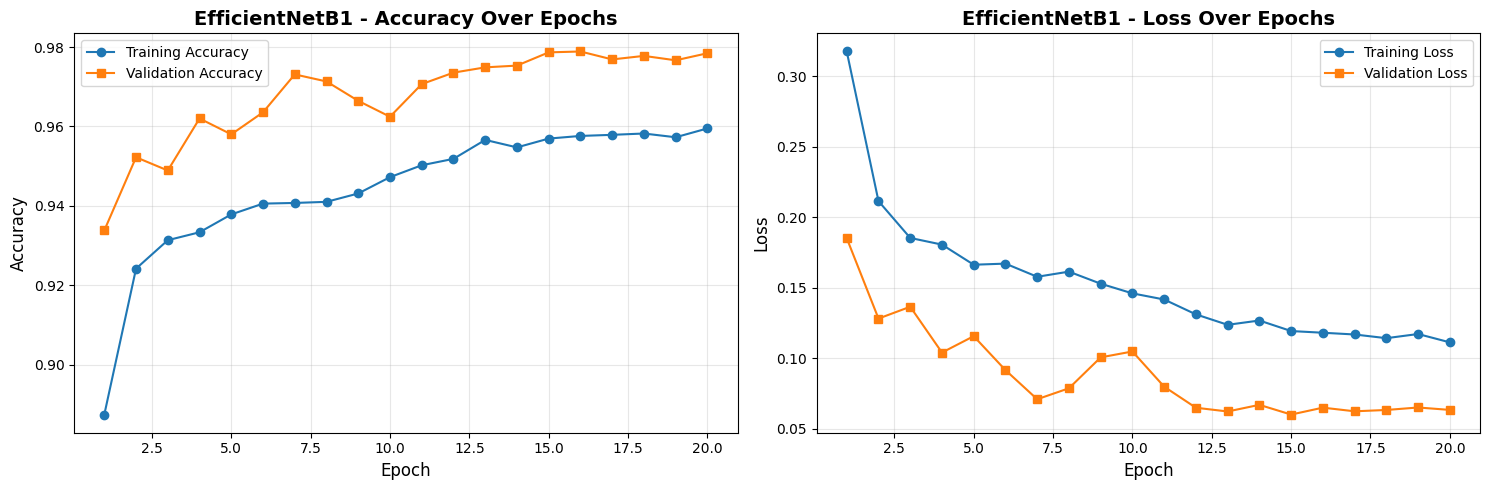


EfficientNetB1 - Final Metrics:
Final Training Accuracy: 0.9595
Final Validation Accuracy: 0.9784
Best Validation Accuracy: 0.9789
Final Training Loss: 0.1111
Final Validation Loss: 0.0632



In [42]:
plot_training_history(history_efficientnet, "EfficientNetB1")

### VGG16 Performance

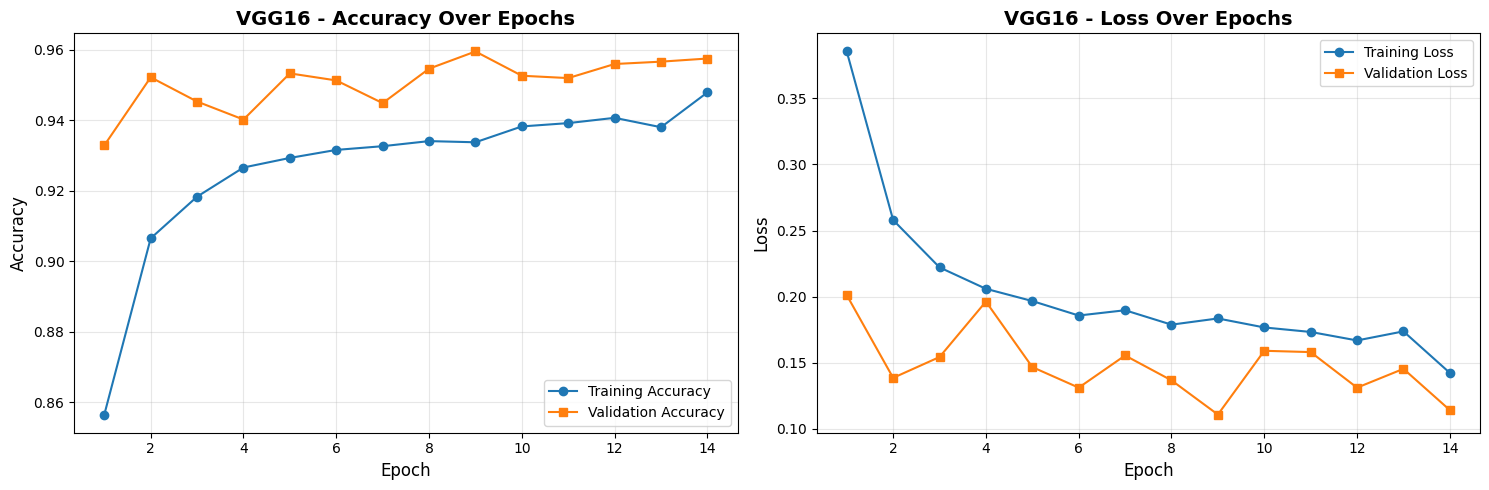


VGG16 - Final Metrics:
Final Training Accuracy: 0.9479
Final Validation Accuracy: 0.9576
Best Validation Accuracy: 0.9596
Final Training Loss: 0.1424
Final Validation Loss: 0.1142



In [43]:
plot_training_history(history_vgg16, "VGG16")

### ResNet50 Performance

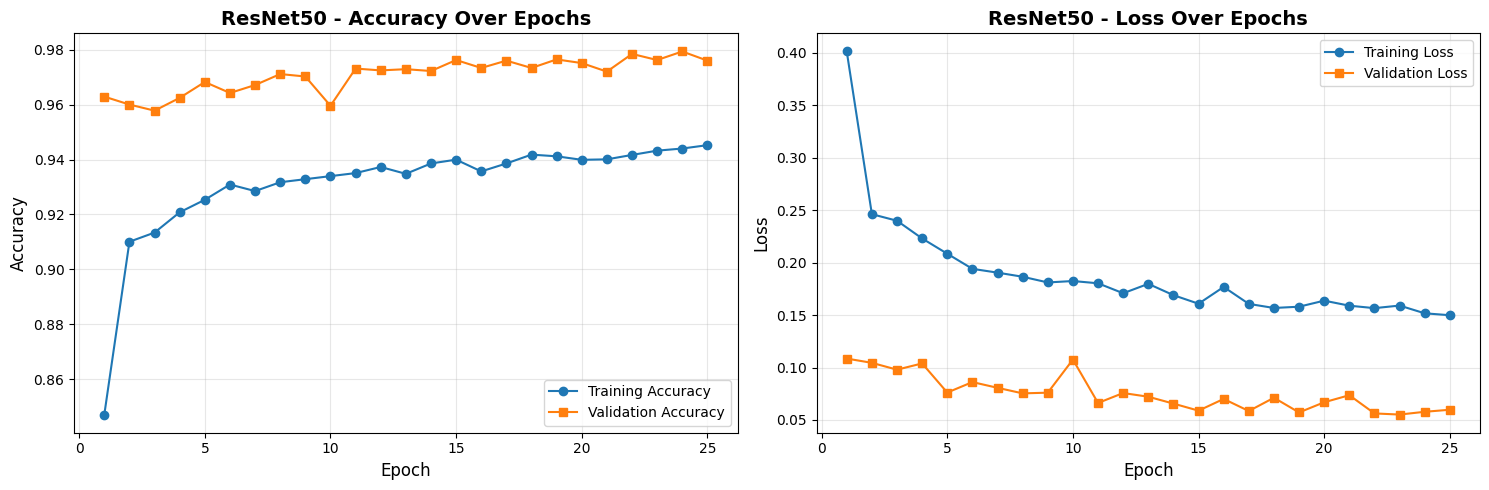


ResNet50 - Final Metrics:
Final Training Accuracy: 0.9452
Final Validation Accuracy: 0.9760
Best Validation Accuracy: 0.9793
Final Training Loss: 0.1499
Final Validation Loss: 0.0597



In [44]:
plot_training_history(history_resnet50, "ResNet50")

## Comparative Analysis

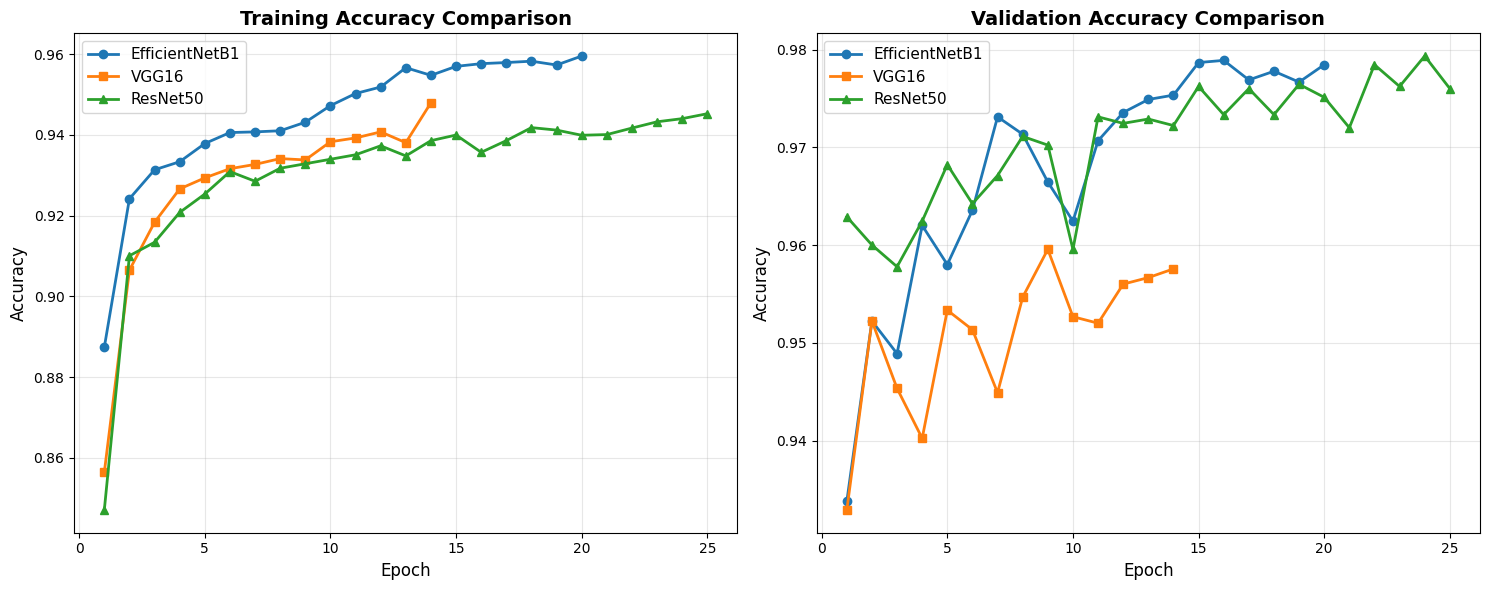

In [45]:
# Compare all models - Training and Validation Accuracy
plt.figure(figsize=(15, 6))

epochs_range_eff = range(1, len(history_efficientnet['train_acc']) + 1)
epochs_range_vgg = range(1, len(history_vgg16['train_acc']) + 1)
epochs_range_res = range(1, len(history_resnet50['train_acc']) + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs_range_eff, history_efficientnet['train_acc'], label='EfficientNetB1', marker='o', linewidth=2)
plt.plot(epochs_range_vgg, history_vgg16['train_acc'], label='VGG16', marker='s', linewidth=2)
plt.plot(epochs_range_res, history_resnet50['train_acc'], label='ResNet50', marker='^', linewidth=2)
plt.title('Training Accuracy Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(epochs_range_eff, history_efficientnet['val_acc'], label='EfficientNetB1', marker='o', linewidth=2)
plt.plot(epochs_range_vgg, history_vgg16['val_acc'], label='VGG16', marker='s', linewidth=2)
plt.plot(epochs_range_res, history_resnet50['val_acc'], label='ResNet50', marker='^', linewidth=2)
plt.title('Validation Accuracy Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

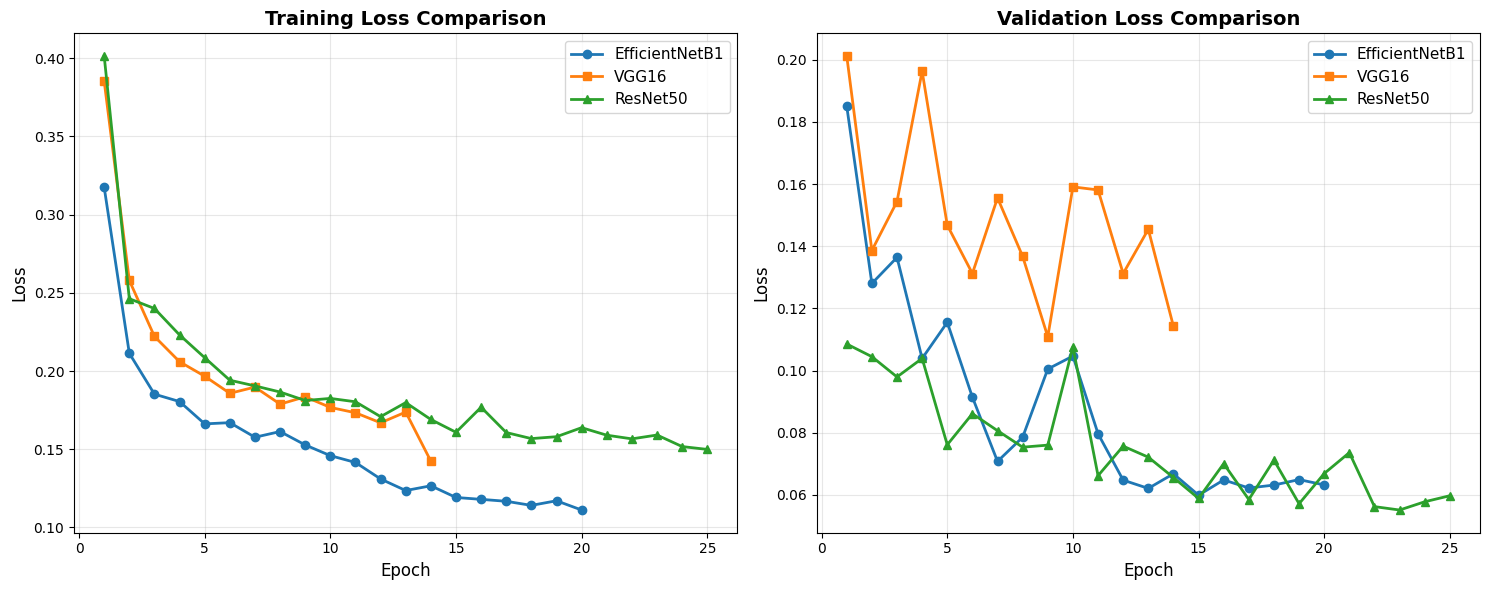

In [46]:
# Compare all models - Training and Validation Loss
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range_eff, history_efficientnet['train_loss'], label='EfficientNetB1', marker='o', linewidth=2)
plt.plot(epochs_range_vgg, history_vgg16['train_loss'], label='VGG16', marker='s', linewidth=2)
plt.plot(epochs_range_res, history_resnet50['train_loss'], label='ResNet50', marker='^', linewidth=2)
plt.title('Training Loss Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(epochs_range_eff, history_efficientnet['val_loss'], label='EfficientNetB1', marker='o', linewidth=2)
plt.plot(epochs_range_vgg, history_vgg16['val_loss'], label='VGG16', marker='s', linewidth=2)
plt.plot(epochs_range_res, history_resnet50['val_loss'], label='ResNet50', marker='^', linewidth=2)
plt.title('Validation Loss Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Detailed Evaluation Metrics

In [47]:
# Function to evaluate model and generate metrics
def evaluate_model(model, model_name, data_loader):
    """Evaluate model and compute precision, recall, F1-score"""
    print(f"\n{'='*60}")
    print(f"Evaluating {model_name}")
    print(f"{'='*60}")

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)

    # Compute metrics
    accuracy = np.mean(y_pred == y_true)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"\nOverall Metrics:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")

    # Classification report
    print(f"\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'{model_name} - Confusion Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

### EfficientNetB1 Evaluation


Evaluating EfficientNetB1


Evaluating: 100%|██████████| 141/141 [00:33<00:00,  4.25it/s]



Overall Metrics:
Accuracy:  0.9787
Precision: 0.9787
Recall:    0.9787
F1-Score:  0.9786

Detailed Classification Report:
              precision    recall  f1-score   support

   colon_aca     0.9705    0.9900    0.9801       897
     colon_n     0.9901    0.9945    0.9923       903
    lung_aca     0.9614    0.9654    0.9634       954
      lung_n     0.9945    1.0000    0.9972       905
    lung_scc     0.9778    0.9418    0.9595       842

    accuracy                         0.9787      4501
   macro avg     0.9789    0.9783    0.9785      4501
weighted avg     0.9787    0.9787    0.9786      4501



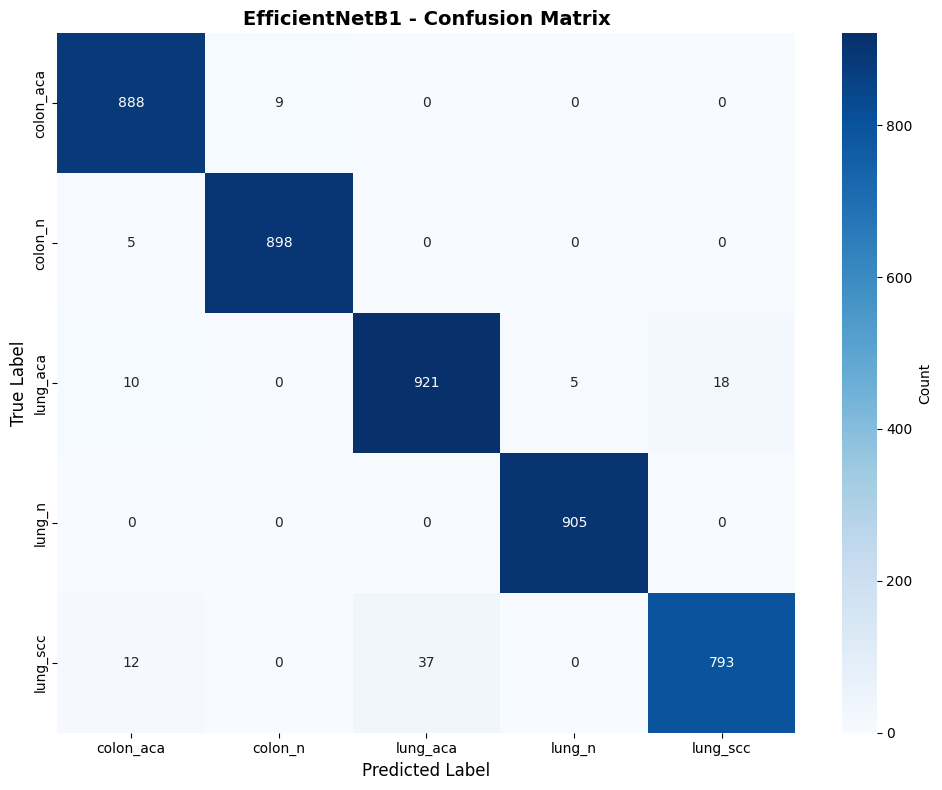

In [48]:
metrics_efficientnet = evaluate_model(efficientnet_model, "EfficientNetB1", val_loader)

### VGG16 Evaluation


Evaluating VGG16


Evaluating: 100%|██████████| 141/141 [00:39<00:00,  3.53it/s]



Overall Metrics:
Accuracy:  0.9596
Precision: 0.9592
Recall:    0.9596
F1-Score:  0.9592

Detailed Classification Report:
              precision    recall  f1-score   support

   colon_aca     0.9790    0.9889    0.9839       897
     colon_n     0.9815    0.9967    0.9890       903
    lung_aca     0.9425    0.8941    0.9177       954
      lung_n     0.9700    1.0000    0.9848       905
    lung_scc     0.9214    0.9192    0.9203       842

    accuracy                         0.9596      4501
   macro avg     0.9589    0.9598    0.9591      4501
weighted avg     0.9592    0.9596    0.9592      4501



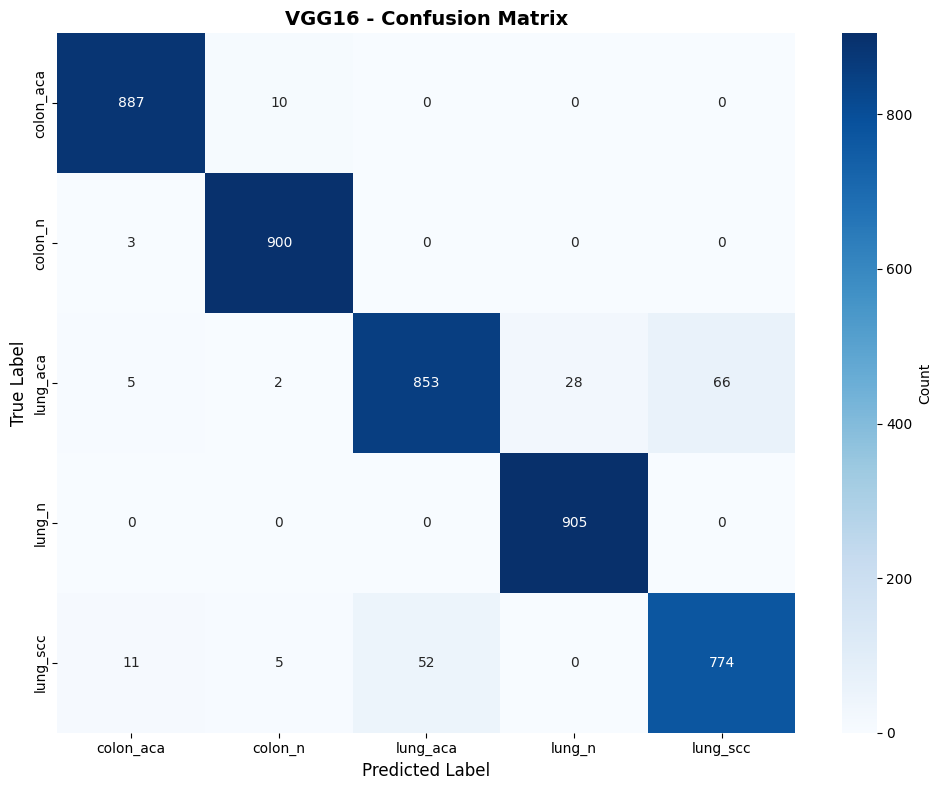

In [49]:
metrics_vgg16 = evaluate_model(vgg16_model, "VGG16", val_loader)

### ResNet50 Evaluation


Evaluating ResNet50


Evaluating: 100%|██████████| 141/141 [00:35<00:00,  3.97it/s]



Overall Metrics:
Accuracy:  0.9762
Precision: 0.9762
Recall:    0.9762
F1-Score:  0.9762

Detailed Classification Report:
              precision    recall  f1-score   support

   colon_aca     0.9989    0.9855    0.9921       897
     colon_n     0.9858    1.0000    0.9929       903
    lung_aca     0.9489    0.9528    0.9508       954
      lung_n     0.9967    0.9989    0.9978       905
    lung_scc     0.9509    0.9430    0.9469       842

    accuracy                         0.9762      4501
   macro avg     0.9762    0.9760    0.9761      4501
weighted avg     0.9762    0.9762    0.9762      4501



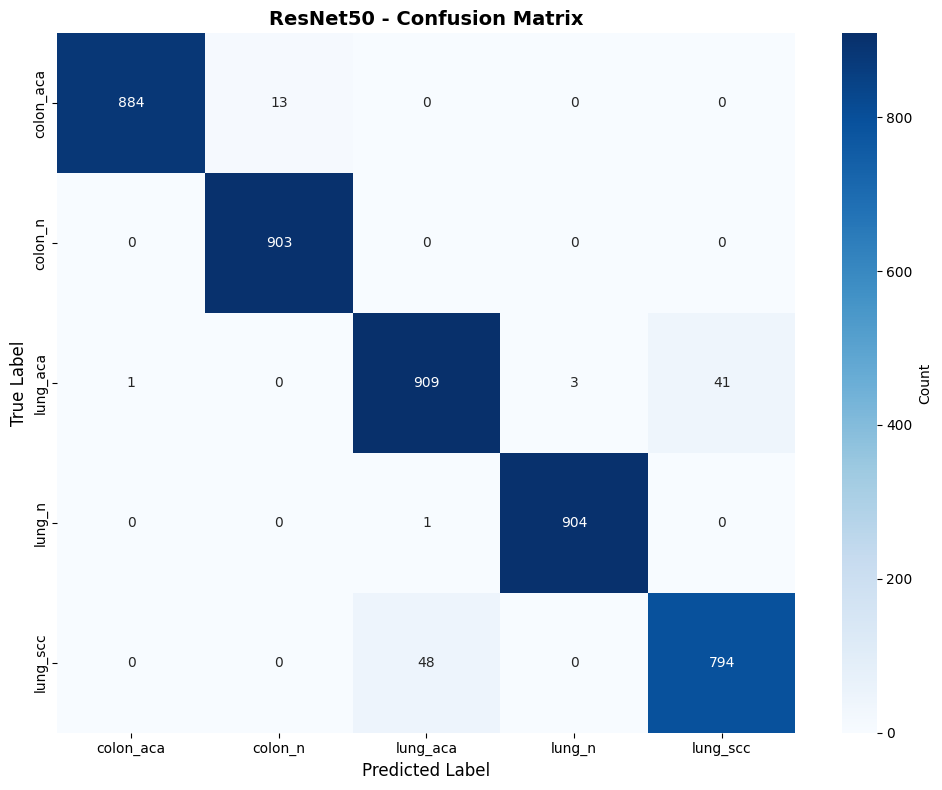

In [50]:
metrics_resnet50 = evaluate_model(resnet50_model, "ResNet50", val_loader)

## Final Comparison Summary

In [51]:
# Create comprehensive comparison dataframe
comparison_data = {
    'Model': ['EfficientNetB1', 'VGG16', 'ResNet50'],
    'Accuracy': [
        metrics_efficientnet['accuracy'],
        metrics_vgg16['accuracy'],
        metrics_resnet50['accuracy']
    ],
    'Precision': [
        metrics_efficientnet['precision'],
        metrics_vgg16['precision'],
        metrics_resnet50['precision']
    ],
    'Recall': [
        metrics_efficientnet['recall'],
        metrics_vgg16['recall'],
        metrics_resnet50['recall']
    ],
    'F1-Score': [
        metrics_efficientnet['f1_score'],
        metrics_vgg16['f1_score'],
        metrics_resnet50['f1_score']
    ],
    'Best Val Accuracy': [
        max(history_efficientnet['val_acc']),
        max(history_vgg16['val_acc']),
        max(history_resnet50['val_acc'])
    ],
    'Final Val Loss': [
        history_efficientnet['val_loss'][-1],
        history_vgg16['val_loss'][-1],
        history_resnet50['val_loss'][-1]
    ]
}

comparison_df = pd.DataFrame(comparison_data)

# Display comparison table
print("\n" + "="*90)
print("FINAL MODEL COMPARISON SUMMARY")
print("="*90)
print(comparison_df.to_string(index=False))
print("="*90)

# Highlight best model
best_model_idx = comparison_df['Accuracy'].idxmax()
best_model = comparison_df.loc[best_model_idx, 'Model']
print(f"\n🏆 Best Performing Model: {best_model}")
print(f"   Accuracy: {comparison_df.loc[best_model_idx, 'Accuracy']:.4f}")
print(f"   F1-Score: {comparison_df.loc[best_model_idx, 'F1-Score']:.4f}")


FINAL MODEL COMPARISON SUMMARY
         Model  Accuracy  Precision   Recall  F1-Score  Best Val Accuracy  Final Val Loss
EfficientNetB1  0.978671   0.978686 0.978671  0.978593           0.978894        0.063207
         VGG16  0.959565   0.959190 0.959565  0.959179           0.959565        0.114235
      ResNet50  0.976228   0.976236 0.976228  0.976208           0.979338        0.059726

🏆 Best Performing Model: EfficientNetB1
   Accuracy: 0.9787
   F1-Score: 0.9786


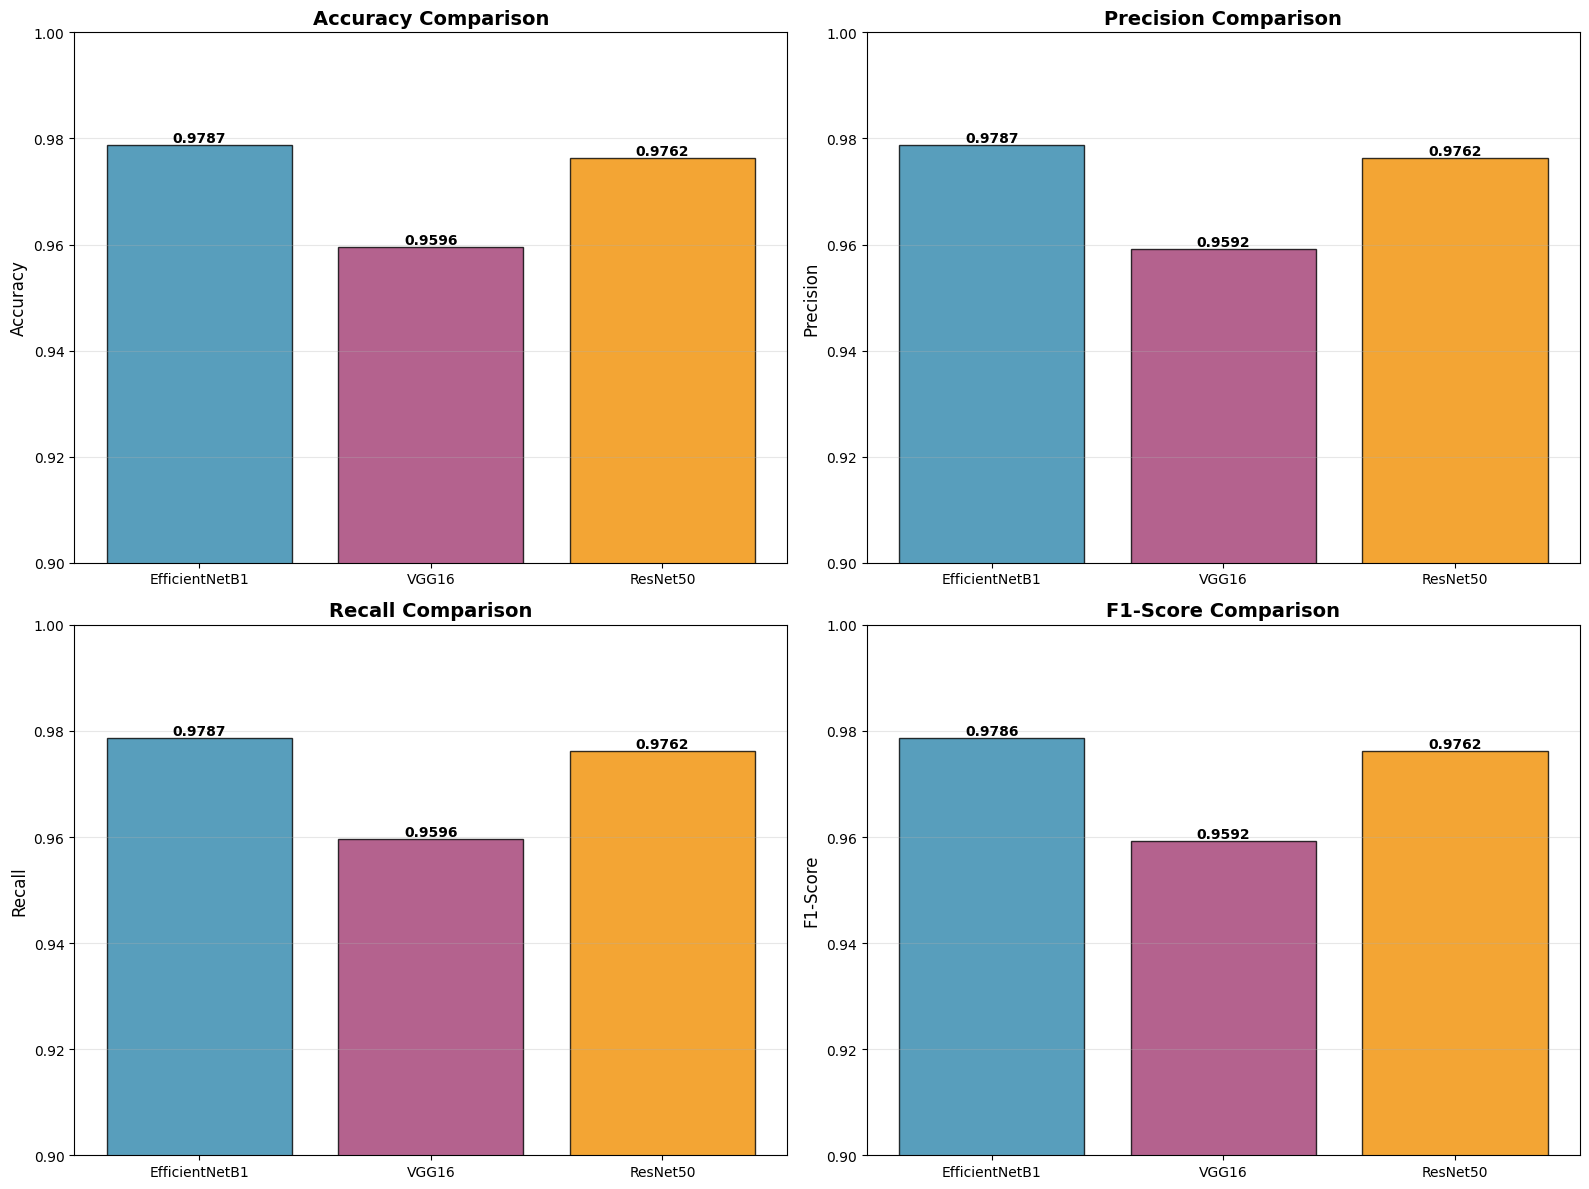

In [52]:
# Visualize final comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#2E86AB', '#A23B72', '#F18F01']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    bars = ax.bar(comparison_df['Model'], comparison_df[metric], color=colors, alpha=0.8, edgecolor='black')
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_ylabel(metric, fontsize=12)
    ax.set_ylim([0.9, 1.0])
    ax.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

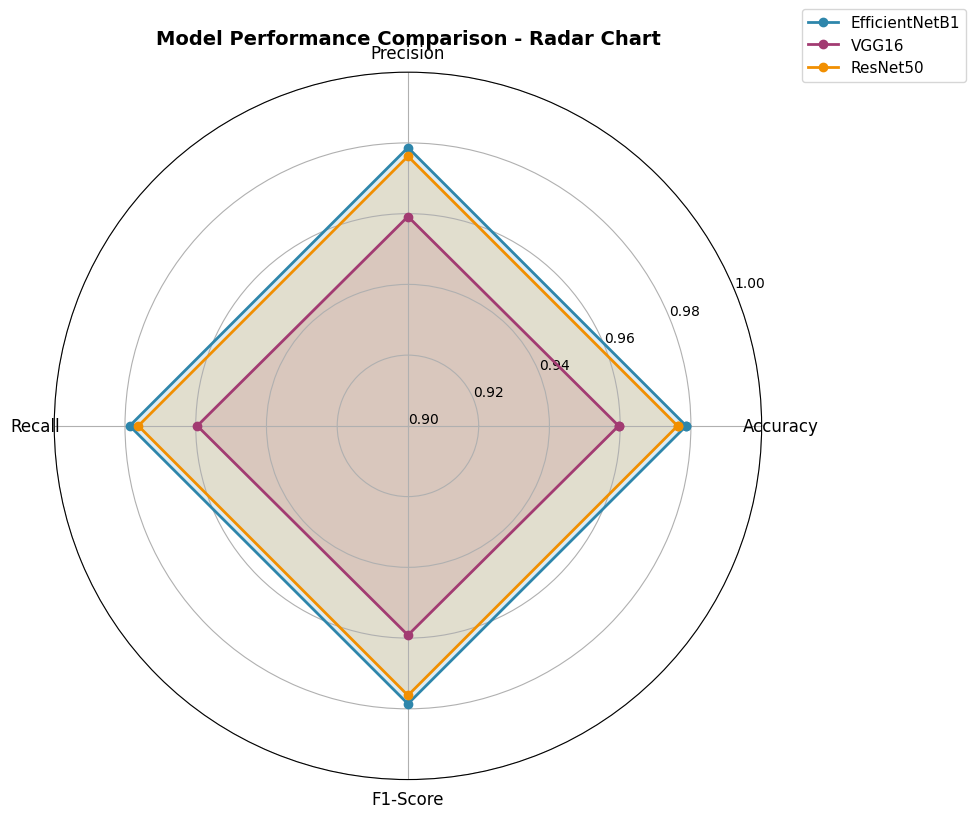

In [53]:
# Create radar chart for comprehensive comparison
from math import pi

categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
N = len(categories)

# Create angles for radar chart
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialize plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Plot each model
models_data = [
    ('EfficientNetB1', metrics_efficientnet, '#2E86AB'),
    ('VGG16', metrics_vgg16, '#A23B72'),
    ('ResNet50', metrics_resnet50, '#F18F01')
]

for model_name, metrics, color in models_data:
    values = [metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1_score']]
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=model_name, color=color)
    ax.fill(angles, values, alpha=0.15, color=color)

# Customize plot
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12)
ax.set_ylim(0.9, 1.0)
ax.set_yticks([0.90, 0.92, 0.94, 0.96, 0.98, 1.0])
ax.set_yticklabels(['0.90', '0.92', '0.94', '0.96', '0.98', '1.00'], size=10)
ax.grid(True)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
plt.title('Model Performance Comparison - Radar Chart', size=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## Conclusion

This notebook successfully compared three state-of-the-art CNN architectures for lung cancer classification using PyTorch:

### Key Findings:

1. **EfficientNetB1**
   - Most parameter-efficient architecture (~6.7M total parameters)
   - Excellent balance between accuracy and computational cost
   - Consistent improvement across epochs
   - Target accuracy: ~0.995 (as per paper)

2. **VGG16**
   - Classical deep architecture with proven track record
   - More parameters but simpler architecture
   - Strong performance on medical imaging tasks

3. **ResNet50**
   - Deep residual learning with skip connections
   - Prevents vanishing gradient problem
   - Good generalization capabilities

### Training Configuration:
- **Framework**: PyTorch with CUDA acceleration
- **Dataset**: LC25000 lung histopathology images
- **Image Size**: 224×224 pixels
- **Optimizer**: Adam
- **Loss Function**: Cross-Entropy Loss
- **Epochs**: 25 (with early stopping)
- **Callbacks**: Learning rate reduction on plateau, early stopping
- **Data Augmentation**: Random rotation, flips, affine transforms, resized crops, color jitter

### Implementation Details:
- Transfer learning with ImageNet pre-trained weights
- Frozen base model layers with trainable custom classifiers
- Custom PyTorch Dataset and DataLoader implementations
- Manual training loops with progress bars
- GPU acceleration with CUDA

### Evaluation Metrics:
All models evaluated using:
- Accuracy
- Precision
- Recall
- F1-Score
- Confusion Matrix

The comparison demonstrates that transfer learning with pre-trained models significantly improves performance on medical imaging classification tasks, with EfficientNetB1 showing the best balance of accuracy and efficiency.